In [1]:
# !pip install matplotlib tqdm numpy

In [2]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
from multiprocessor.scheduler import MultiprocessorSchedulerType
from multiprocessor.partitioner import FirstFit, NextFit, BestFit, WorstFit

# self-written modules
from utils.metrics import MultiprocessorFeasibility, calculate_success_rate
from utils.plotters import plot_average_execution_time
from utils.parse import parse_task_file
from multiprocessor.feasibility.review import review_task_sets_in_parallel_multi

import numpy as np


In [3]:
# calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(MultiprocessorFeasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(MultiprocessorFeasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [4]:
# process task sets for Plot 1 and 2 (by number of tasks)

def average_execution_time_by_workers(config, folder_name):
    """
    Process task sets organized by number of tasks (like in 4-tasks, 10-tasks).
    """
    # subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name))
    # print(subfolders)
    execution_times = []

    workers = config["number_of_workers"]

    for worker_quantity in workers:
        start_time = time()

        print(f"Executing with: {worker_quantity} workers.")
        #for subfolder in subfolders:
        #print(f"Subfolder: {subfolder}")
        num_tasks = 100
        #print(f"\nProcessing {num_tasks} tasks in {subfolder}")
        print(f"Evaluating algorithm: {config["alg"].name}")
        schedule_stats = review_task_sets_in_parallel_multi(algorithm=config["alg"],
                                                        folder_name=folder_name,
                                                        num_processors=config["processors"],
                                                        #num_clusters=config["clusters"],
                                                        heuristic=config["heuristic"],
                                                        number_of_workers=worker_quantity)
            # success_rate = calculate_success_rate(schedule_stats) #TODO execution time
            # execution_times[num_tasks] = success_rate
        end_time = time() - start_time
        print(end_time)

        execution_times.append(
            {
                "workers": worker_quantity,
                "time": end_time
            }
        )

    return execution_times

In [5]:
def get_workers_range(from_val, to_val):
    return list(range(from_val, to_val + 1))

config_to_evaluate = {
        "alg": MultiprocessorSchedulerType.PARTITIONED_EDF,
        "heuristic": BestFit(decreasing_utilisation=True, verbose=False),
        "sorting": 'du',
        "processors": 8,
        #"clusters": 4,
        "number_of_workers": get_workers_range(1, 32)
    }
# python3 main.py tasksets-multiprocessor 8 partitioned -H bf -s du

results = average_execution_time_by_workers(config=config_to_evaluate, folder_name="tasksets-multiprocessor/")


Executing with: 1 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.6023919582366943
Executing with: 2 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.33167529106140137
Executing with: 3 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.2922070026397705
Executing with: 4 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.3288731575012207
Executing with: 5 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.31595921516418457
Executing with: 6 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.28848791122436523
Executing with: 7 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.3984851837158203
Executing with: 8 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000
0.2883284091949463
Executing with: 9 workers.
Evaluating algorithm: PARTITIONED_EDF
Total files considered: 1000

Time taken for 1 workers: 0.6023919582366943
Time taken for 2 workers: 0.33167529106140137
Time taken for 3 workers: 0.2922070026397705
Time taken for 4 workers: 0.3288731575012207
Time taken for 5 workers: 0.31595921516418457
Time taken for 6 workers: 0.28848791122436523
Time taken for 7 workers: 0.3984851837158203
Time taken for 8 workers: 0.2883284091949463
Time taken for 9 workers: 0.25819849967956543
Time taken for 10 workers: 0.29331111907958984
Time taken for 11 workers: 0.29918909072875977
Time taken for 12 workers: 0.3089897632598877
Time taken for 13 workers: 0.31046414375305176
Time taken for 14 workers: 0.3111727237701416
Time taken for 15 workers: 0.3132202625274658
Time taken for 16 workers: 0.27316761016845703
Time taken for 17 workers: 0.31712865829467773
Time taken for 18 workers: 0.3072807788848877
Time taken for 19 workers: 0.32519006729125977
Time taken for 20 workers: 0.3289055824279785
Time taken for 21 workers: 0.34537315368652344
Time taken for 22 workers: 0.338

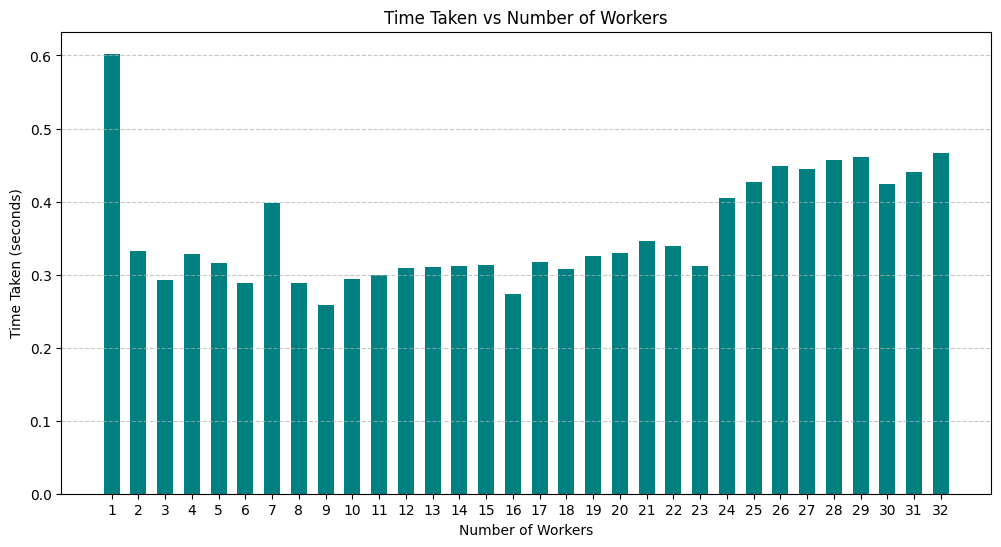

In [6]:
for result in results:
    print(f"Time taken for {result["workers"]} workers: {result["time"]}")

workers = [result["workers"] for result in results]
times = [result["time"] for result in results]

plt.figure(figsize=(12, 6))
plt.bar(workers, times, color='teal', width=0.6)
plt.xlabel('Number of Workers')
plt.ylabel('Time Taken (seconds)')
plt.title('Time Taken vs Number of Workers')
plt.xticks(workers)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()